<a href="https://colab.research.google.com/github/physicsllama/steepest-descent/blob/main/Steepest_descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The purpose of this notebook is to numerically explore some aspects of the steepest descent approximation for integrals, with the broader goal of understanding how valid this approximation is for path integrals.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import cmath

# Set-up and zeroth-order approximations

## Numerical integrator

In [ ]:
# Simple function to integrate a function: rectangular method.
# I ended up using this because scipy's numerical integrator didn't work well with the kinds of functions I'm dealing with.

def integrator(F, limits, delta, lamb):
  dom = np.linspace(limits[0],limits[1], int((limits[1]-limits[0])/delta))
  result = 0
  for i in dom:
    result += F(i, lamb)*delta
  return result

## Defining test functions

In [ ]:
# Trial functions and their minima:

# The following function has a relatively small first derivative near the minimum (not just at minimum)
def f1(x):
  return x**4 - x**2 + 3*x + 4

domain1 = [-3,3]
min1 = -1.08999053607908


# What we'll actually be integrating is the exponential of minus this function.
def integrand1(x, lamb):
  return np.exp(-f1(x) / lamb)


# The following function achieves a minimum only at the boundary of the integration region, but has a local minimum elsewhere.
def f2(x):
  return x**3 - x + 7

domain2 = [-2,2]
min21 = domain2[0]
min22 = 1/np.sqrt(3)

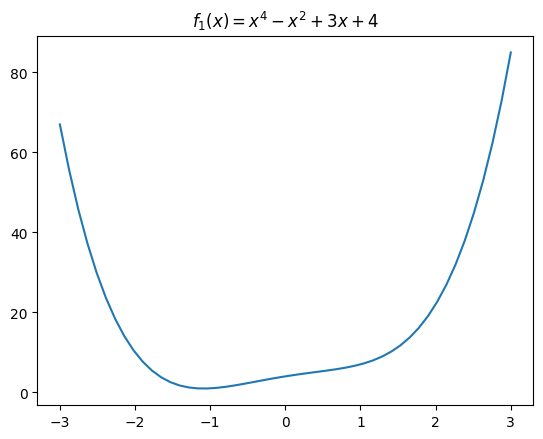

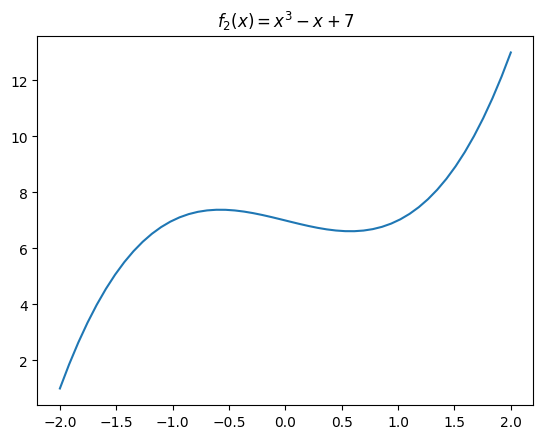

In [ ]:
# We now plot the functions

Domain1 = np.linspace(domain1[0],domain1[1])
func1 = plt.figure()
plt.title('$f_1(x) = x^4-x^2+3x+4$')
plt.plot(Domain1, f1(Domain1))


Domain2 = np.linspace(domain2[0],domain2[1])
func2 = plt.figure()
plt.title('$f_2(x) = x^3-x+7$')
plt.plot(Domain2, f2(Domain2))

plt.show()

## How good is the zeroth-order approximation?

### First function

Let's try the first function:

In [ ]:
def integral1_mine(lamb):
  return integrator(integrand1, [domain1[0], domain1[1]], 0.0001, lamb)

approx10 = np.exp(-f1(min1)/0.08)
print("Integral is " + str(integral1_mine(0.08)))
print("Zeroth order approximation is " + str(approx10))

Integral is 1.3562091395453336e-06
Zeroth order approximation is 6.665803088868744e-06


Pretty good! Off by only an order of magnitude, or less. This is robust to varying lambda (if I make it too small though, both results are of course zero). Let's see it as a function of lambda just to be sure.

Text(0.5, 0, '$\\lambda$')

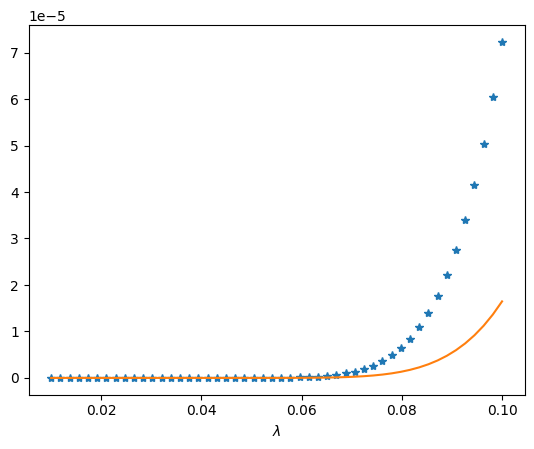

In [ ]:
def steepest10(lamb):
  return np.exp(-f1(min1)/lamb)

lambda_range = np.linspace(0.01, 0.1, 50)
integral1_mine_array = [integral1_mine(i) for i in lambda_range]

plt.plot(lambda_range, steepest10(lambda_range), '*')
plt.plot(lambda_range, integral1_mine_array)
plt.xlabel('$\lambda$')

Indeed, the zeroth order approxmation is a great approximation to the integral for very small lambda. We can do a logplot to see this more clearly:

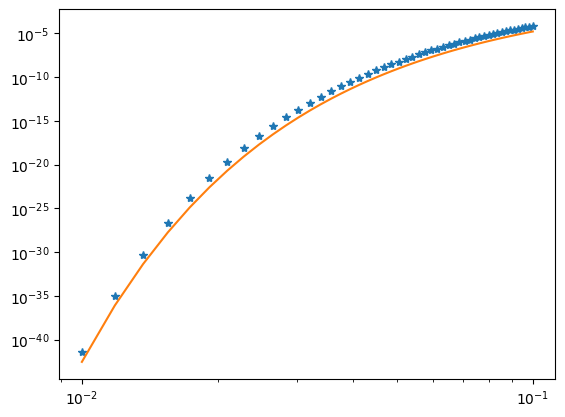

In [ ]:
plt.loglog(lambda_range, steepest10(lambda_range), '*')
plt.loglog(lambda_range, integral1_mine_array)

### Second function

Next, the function whose minimum was at the boundary. We'll print the value of the function there, as well as the value at the other saddle.

In [ ]:
lamb = 0.05

def integrand2(x, Lamb):
  return np.exp(-f2(x)/Lamb)

integral2 = integrator(integrand2, [domain2[0], domain2[1]], 0.0001, lamb)
steepest20 = integrand2(min21, lamb)
fakesteepest2 = integrand2(min22, lamb)
print("Integral is " + str(integral2))
print("Zeroth order approximation is " + str(steepest20))
print("Approximation using local saddle is " + str(fakesteepest2))

Integral is 9.519135286655614e-12
Zeroth order approximation is 2.061153622438558e-09
Approximation using local saddle is 3.4831567088006714e-58


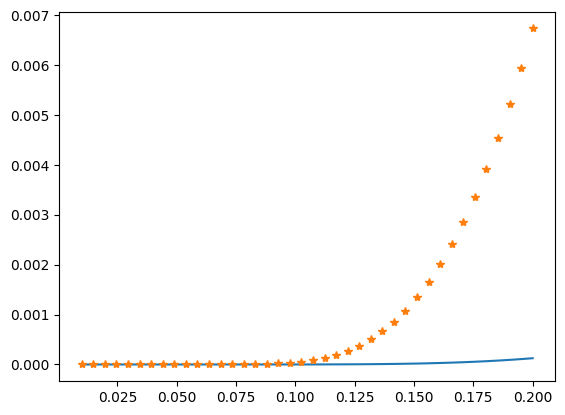

In [ ]:
def integrand2(x, Lamb):
  return np.exp(-f2(x)/Lamb)

def integral2_mine(lamb):
  return integrator(integrand2, [domain2[0], domain2[1]], 0.0001, lamb)

def steepest2(lamb):
  return integrand2(min21, lamb)

LambDomain2 = np.linspace(0.01, 0.2, 40)

integrals = [integral2_mine(i) for i in LambDomain2]

plt.plot(LambDomain2, integrals)
plt.plot(LambDomain2, steepest2(LambDomain2), '*')

The zeroth-order saddlepoint approximation here is off by about 2-3 orders of magnitude depending on my choice of lambda. That's not as good, but still decent.

Using the other saddlepoint (not a global minimum) gives absolute nonsense.

# 1-loop corrections





## How large of a regime do we need to integrate over?

Since most of the integral should come from the region around the peak of the integrand, let's see how large a regime we need to integrate over to get a reasonable part of the integral. Let's see, as a function of lambda, what size the regime needs to be for the integral to be 50% of the total.

In [ ]:
def region_size(f , min, domain, lamb, frac):
  size = 0.001
  partial = 0
  result = integrator(f, [domain[0],domain[1]], 0.0001, lamb)
  while partial/result < frac:
    partial = integrator(f, [min - size, min+size], 0.0001, lamb)
    size += 0.001
  return size

(array([0.19882309]), array([[4.60539472e-08]]))


Text(0, 0.5, 'Region size')

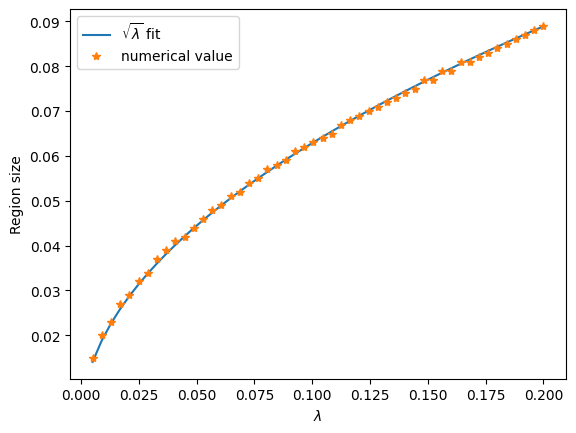

In [ ]:
Lamb = np.linspace(0.005, 0.2, 50)
Region1 = []
guess = []
for i in Lamb:
  Region1.append(region_size(integrand1, min1, domain1, i, 0.5))


def model(x, a):
  return a*np.sqrt(x)
# Fit Region1!

params = scipy.optimize.curve_fit(model, Lamb, Region1)
print(params)
def Model(x):
  return model(x, params[0][0])

plt.plot(Lamb, Model(Lamb), label='$\sqrt{\lambda}$ fit')
plt.plot(Lamb, Region1, '*', label='numerical value')
plt.legend()
plt.xlabel('$\lambda$')
plt.ylabel('Region size')

The curve is well-fit by a square root function! Let's do a logplot to see that it's a straight line (with slope 1/2). This result is robust to varying the fraction of the integral we want to obtain (e.g., for 70% it works just as well.)

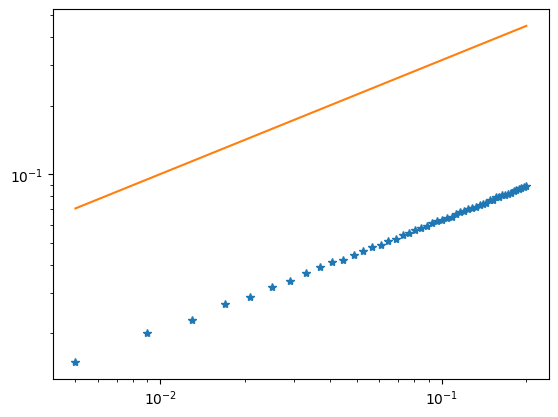

In [ ]:
plt.loglog(Lamb, Region1, '*')
plt.plot(Lamb, Lamb**(1/2))

Lovely. The slope is indeed the same, but it's just shifted because rather than $\sqrt{\lambda}$, it has some prefactor.

### Ok, so what?

Why did we do the analysis above? The nice thing is that if we have
\begin{equation}
I(\lambda) = \int_a^b e^{-f(x)/\lambda} dx
\end{equation}
we've shown that we can well-approximate the integral as
\begin{equation}
I(\lambda) =  \int_{x_m - c \sqrt{\lambda}}^{x_m+c\sqrt{\lambda}} e^{-f(x)/\lambda} dx
\end{equation}
with $c$ some number, and $x_m$ the minimum of $f$. (This result is valid as $\lambda \to 0$). This motivates the change of variables
\begin{equation}
y = \frac{x - x_m}{\sqrt{\lambda}}
\end{equation}
which leads to
\begin{equation}
I(\lambda) = \sqrt{\lambda} \int_{-c}^{c} \exp\left(-\frac{1}{\lambda} f(x_m + \sqrt{\lambda} y) \right) dy
\end{equation}
Since the values of $y$ range up to $O(1)$, the function will be evaluated between $x_m$ and $x_m\pm O(\sqrt{\lambda})$, which give us confidence as physicists to not ask many more questions and perform a Taylor expansion around $x_m$:
\begin{equation}
f(x_m+\sqrt{\lambda} y) \approx f(x_m) + \frac{\lambda}{2} f''(x_m) y^2 + O(\lambda^{3/2})
\end{equation}
where we've used that $x_m$ is a minimum of $f$.

This means that
\begin{equation}
I(\lambda) \sim \sqrt{\lambda} e^{-f(x_m)/\lambda} \int_{-c}^c e^{-f''(x_m) y^2/2} dy
\end{equation}

If $f''(x_m)$ is large enough, we can extend the domain of integration to go from $-\infty$ to $\infty$. More precisely, the standard deviation of the above Gaussian is $1/\sqrt{f''(x_m)}$. If this is smaller than $c$ (for example an order of magnitude smaller), the fictitious contribution from the region beyond $c$ is much smaller than the contribution coming from $[-c,c]$.  This leads us to
\begin{equation}
I(\lambda) \sim \sqrt{\frac{2\pi \lambda}{f''(x_m)}} e^{-f(x_m)/\lambda}
\end{equation}

If you'd like a more careful justification of the formula above, the following article is better https://en.wikipedia.org/wiki/Laplace%27s_method.

The formula must be adjusted for the case where the minimum of $f$ is reached at a boundary of the domain of integration, since there we can't use $f'(x_m)=0$. For that case, we retain the linear term and obtain
\begin{equation}
I(\lambda) \sim \sqrt{\lambda} e^{-f(x_m)/\lambda} \int_0^c e^{-f'(x_m)y/\sqrt{\lambda} - f''(x_m)y^2/2} dy
\end{equation}
where for concreteness we've assumed that the minimum is reached on the lower part of the interval, which means that $f'(x_m)>0$. This, paired with our argument for the previous Gaussian, justifies extending the integral to go from 0 to $\infty$. Carrying out the integral we arrive at
\begin{equation}
I(\lambda) \sim \sqrt{\lambda} e^{-f(x_m)/\lambda} e^{f'(x_m)^2/2f''(x_m)\lambda} \sqrt{\frac{\pi}{2f''(x_m)}} \text{Erf}\left(\frac{f'(x_m)}{\sqrt{2\lambda f''(x_m)}} \right)
\end{equation}
Next we can use the asymptotic form of the error function:
\begin{equation}
\text{Erf}(x) \sim \frac{1}{\sqrt{\pi}x} e^{-x^2}
\end{equation}
to arrive at
\begin{equation}
I(\lambda) \sim \frac{\lambda}{f'(x_m)}  e^{-f(x_m)/\lambda}.
\end{equation}

We'll see in the following section that this formula and the previous one (where the minimum is contained within the interval) very accurately reproduce the full integral.

## 1-loop for first function

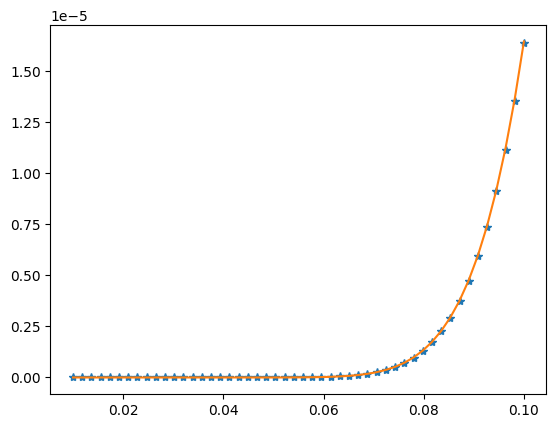

In [ ]:
def steepest11(lamb):
  fpp = 12 * min1**2 - 2
  return np.sqrt(2*np.pi*lamb/fpp) * steepest10(lamb)

plt.plot(lambda_range, steepest11(lambda_range), '*')
plt.plot(lambda_range,integral1_mine_array)

That's absolutely lovely: the steepest descent approximation with the 1-loop correction is a fantastic fit to the full integral. Let's plot their ratio over a slightly larger range of lambda just to be sure.

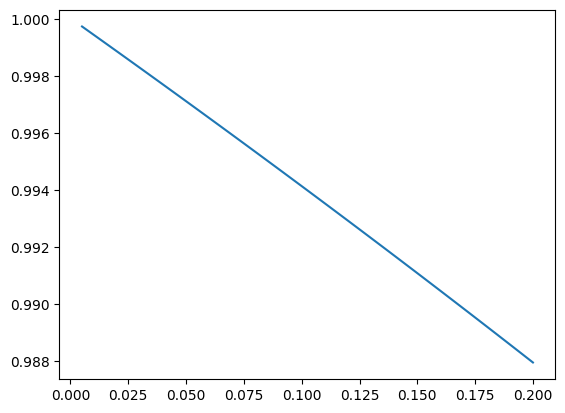

In [ ]:
lambdarange2 = np.linspace(0.005, 0.2, 50)
integral1_mine_array2 = [integral1_mine(i) for i in lambdarange2]
plt.plot(lambdarange2, steepest11(lambdarange2)/ integral1_mine_array2)

Great. So the 1-loop correction is a fantastic approximation - much better than just including the exponential term.


## 1-loop for second function

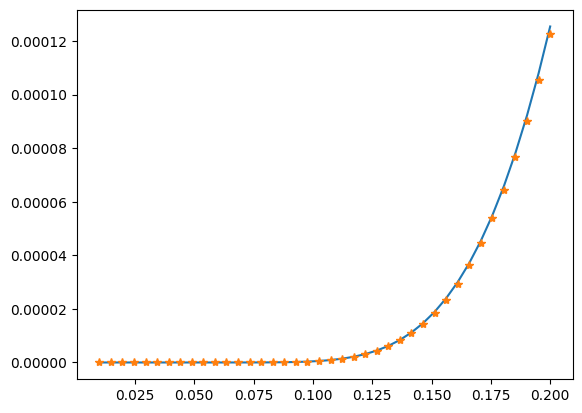

In [ ]:
def steepest21(lamb):
  fp = 3 * min21**2 - 1
  return lamb / fp * steepest2(lamb)

plt.plot(LambDomain2, integrals)
plt.plot(LambDomain2, steepest21(LambDomain2), '*')

That's also amazing. We used a slightly different 1-loop formula here because the minimum is at the boundary, but it also gives the correct result.

# Subleading saddles

The purpose of this subsection is to get a sense of when subleading saddles start to matter (in part motivated by recent Page curve computations). I'm curious about how valid the SPA is when we're near regimes where different saddles exchange dominance.

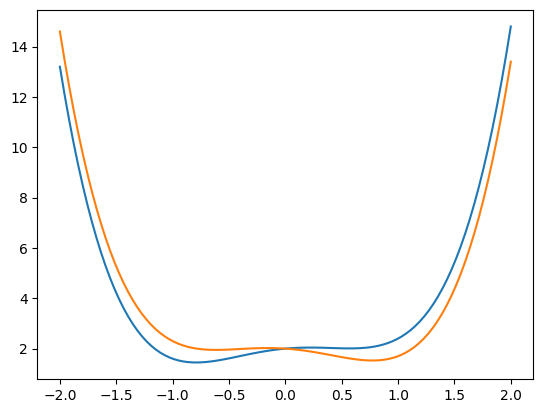

In [ ]:
# Here is a function with two minima. We'll let a range from -0.1 to 0.1. As it changes sign, the minima exchange dominance.
def f3(x, a):
  return (x)**4 - x**2 + a*x + 2


def f3p(x,a):
  return 4*x**3 - 2*x + a

def f3pp(x,a):
  return 12*x**2 - 2

# We'll need to numerically find the argmin of f3 for different values of a.
def argmin(f, a, domain, delta):
  dom = np.linspace(domain[0], domain[1], int(1/delta))
  index = np.argmin(f(dom, a))
  return dom[index]


# Let's plot f3 for a = 0.5, and for a = -0.9
domain3 = [-2,2]
dom3 = np.linspace(domain3[0],domain3[1], 100)
plt.plot(dom3, f3(dom3, 0.4))
plt.plot(dom3, f3(dom3, -0.3))

In [ ]:
def steepest3(a):
  delta = 0.0001
  domain = [-2,2]
  xmin = argmin(f3, a, domain, delta)
  return np.exp(-f3(xmin,a)/0.05)*np.sqrt(2*np.pi*0.05/f3pp(xmin, a))


def integrand3(x,a):
  return np.exp(-f3(x,a)/0.05)
#define next a function which integrates numerically


def integral3(a):
  return integrator(integrand3, [-2,2], 0.001, a)

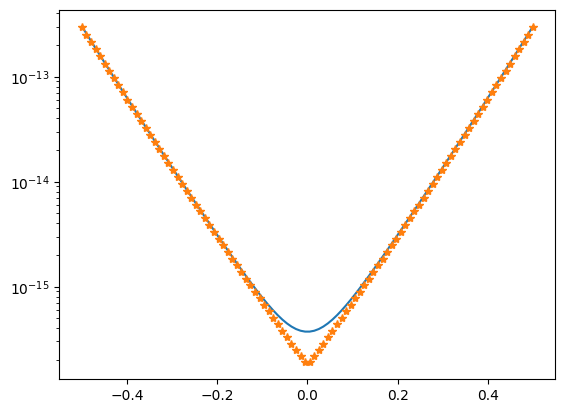

In [ ]:
a_range = np.linspace(-0.5,0.5, 100)

steepest_array = [steepest3(i) for i in a_range]
integral_array = [integral3(i) for i in a_range]

plt.yscale("log")
plt.plot(a_range, integral_array)
plt.plot(a_range, steepest_array, '*')

The saddlepoint approximation works quite well, with noticeable issues near the phase transition however. What if we take both saddles into account always, including the subleading one?

In [ ]:
def local_min(f, a, domain, delta):
  dom = np.linspace(domain[0], domain[1], int(1/delta))
  indices = scipy.signal.argrelextrema(f(dom,a), np.less)
  index1 = indices[0][0]
  index2 = indices[0][1]
  if f(dom[index1],a)>f(dom[index2],a):
    return dom[index1]
  else:
    return dom[index2]

In [ ]:
def steepest3_both(a):
  delta = 0.0001
  domain = [-2,2]
  xmin1 = argmin(f3, a, domain, delta)
  xmin2 = local_min(f3, a, domain, delta)
  return np.exp(-f3(xmin1,a)/0.05)*np.sqrt(2*np.pi*0.05/f3pp(xmin1, a)) + np.exp(-f3(xmin2,a)/0.05)*np.sqrt(2*np.pi*0.05/f3pp(xmin2, a))

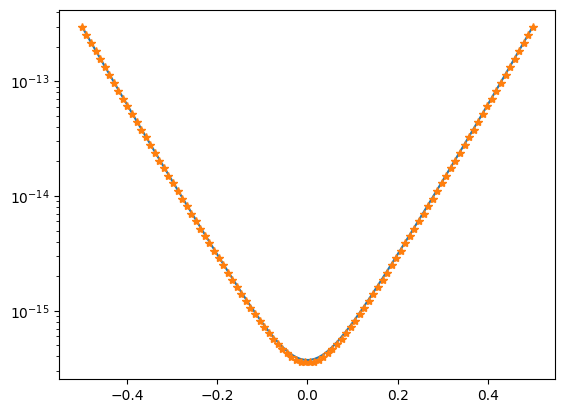

In [ ]:
a_range = np.linspace(-0.5,0.5, 100)

steepest_array_both = [steepest3_both(i) for i in a_range]
integral_array = [integral3(i) for i in a_range]

plt.yscale("log")
plt.plot(a_range, integral_array)
plt.plot(a_range, steepest_array_both, '*')

Wonderful! Including both saddles in the saddle point approximation yields a much better result near the phase transition, and also smoothes out the singular behavior.

## One final example with real functions

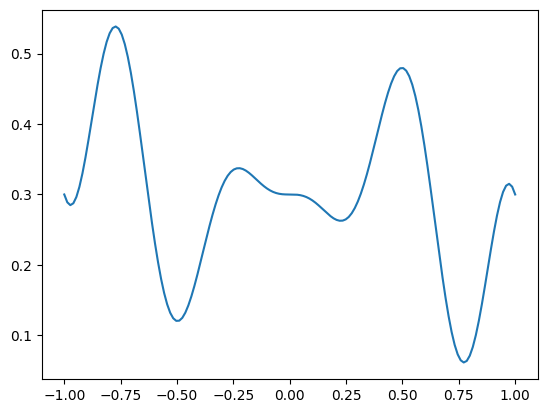

In [ ]:
# Let's try one last real function, combining the techniques we used before.
# This function has a bunch of local minima.
def f4(x):
  return ((x)**4 - x**2)*np.sin(10*x) + 0.3

def f4pp(x):
  return -2*np.sin(10*x)*(1-56*x**2 + 50*x**4) + np.cos(10*x)*40*x*(2*x**2-1)

def integrand4(x, lamb):
  return np.exp(-f4(x) / lamb)


dom4 = np.linspace(-1,1,150)
plt.plot(dom4, f4(dom4))

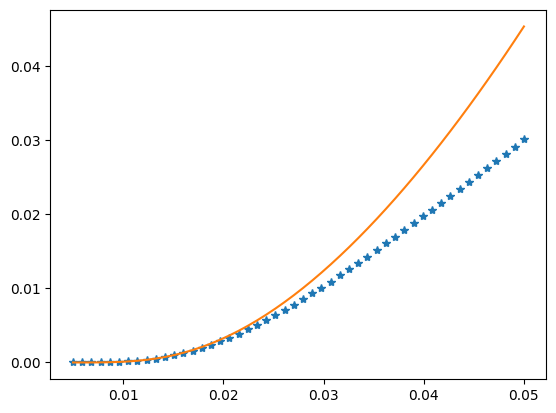

In [ ]:
lamb_range = np.linspace(0.005, 0.05, 50)

def Argmin(f, domain, delta):
  dom = np.linspace(domain[0], domain[1], int(1/delta))
  index = np.argmin(f(dom))
  return dom[index]

def steepest4(lamb):
  delta = 0.0001
  domain = [-1,1]
  xmin = Argmin(f4, domain, delta)
  return  np.exp(-f4(xmin)/lamb) * np.sqrt(2*np.pi*lamb/f4pp(xmin))

integral4 = [integrator(integrand4, [-1,1], 0.001, i) for i in lamb_range]

plt.plot(lamb_range, steepest4(lamb_range), '*')
plt.plot(lamb_range, integral4)

It works extremely well for small $\lambda$, but getting up to values of $\lambda$ around 0.1 it's a worse approximation. Including other minima will likely make it better. **Exercise**: try it!

# Complex functions and steepest descent contours

First, let's check that our numerical integrator is still good for complex functions. We'll use it for a case where we know the answer. For example, e^{ix^2} from 0 to infinity.

In [ ]:
def check_integrand(x, lamb):
  return np.exp(1j*x**2 * lamb)

mine = integrator(check_integrand, [0, 1000], 0.0001, 1)
result = 0.626657 + 0.626657j

difference = mine - result
print(difference)

(-7.756965615213218e-05-0.00048430731807957983j)


It seems to work somewhat decently. However, if the limit of integration is too high, and delta is not small enough, the result is terrible. I need to ensure that delta is small enough to capture oscillations. This will depend on what values of lambda I choose later on, so I should be careful. In particular, one thing I might want to do is check the smallest wavelengths of oscillations and make delta about 10 times smaller than this.

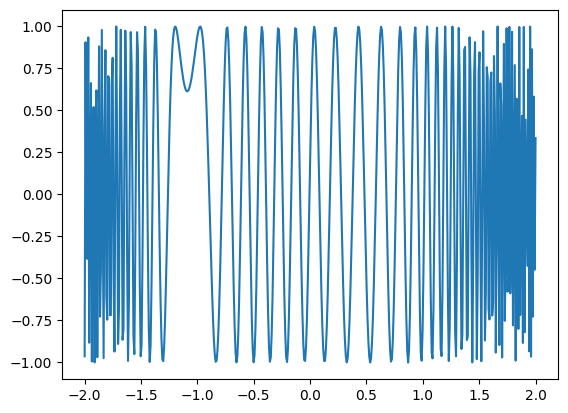

In [ ]:
# First just check that the steepest descent approximation works for my normal function f1.
def cIntegrand1(x, lamb):
  return np.exp(1j*f1(x)/ lamb)

X = np.linspace(-2,2, 500)

plt.plot(X, np.real(cIntegrand1(X,0.0818)))

# We see that we need delta on the order of 0.001 to get a decent numerical estimate of the integral, when lambda = 0.01

Text(0.5, 0, '$\\lambda$')

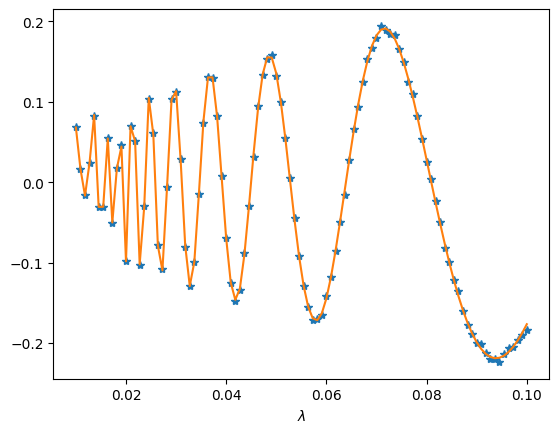

In [ ]:
def complex_steepest1(lamb):
  fpp = 12 * min1**2 - 2
  return np.sqrt(2j*np.pi*lamb/fpp) * cIntegrand1(min1, lamb)

#range of lambda
lambdas = np.linspace(0.01,0.1, 100)

#compute integrals numerically
numerical_integrals = [integrator(cIntegrand1, [-2,2], 0.001, i) for i in lambdas]
real_numerical_integrals = [np.imag(i) for i in numerical_integrals]

complex_steepest_list = complex_steepest1(lambdas)
real_complex_steepest1 = [np.imag(i) for i in complex_steepest_list]

#compare real parts of numerical integrals with the steepest1 approx
plt.plot(lambdas, real_numerical_integrals, '*')
plt.plot(lambdas, real_complex_steepest1)
plt.xlabel('$\lambda$')

Great - it seems like the steepest descent approximation (including the 1-loop piece) works extremely well!


Let's now try an example where we can't deform the integration contour to pass through the saddlepoint.

In [ ]:
# Define a function with a branch cut in the complex plane which prohibit deforming to a steepest descent contour.
# The branch cut here is on the Im(x) = i line, and the saddlepoint is at x = 2i.
def f_branch(x):
  return cmath.sqrt(x-1j) + cmath.sqrt(-x+1j) + 1j*x*np.sin(np.pi/4)

def integrand_branch(x, lamb):
  return np.exp(1j*f_branch(x) / lamb)

In [ ]:
numerical_value = [np.real(integrator(integrand_branch, [-1,1], 0.0001, i)) for i in lambdas]

In [ ]:
def complex_steepest_branch(lamb):
  fpp = 1/(2*np.sqrt(2))
  return np.sqrt(2j*np.pi*lamb/fpp) * integrand_branch(2j, lamb)

In [ ]:
saddle_branch = [np.real(complex_steepest_branch(i)) for i in lambdas]

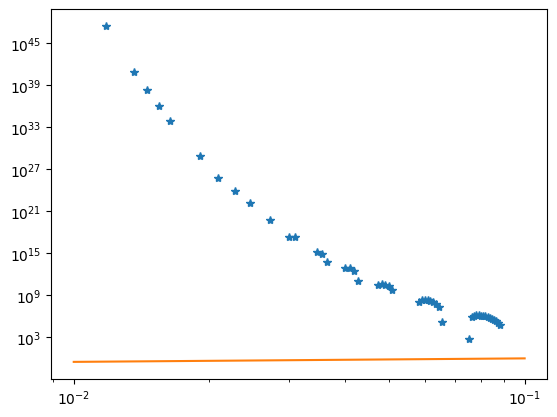

In [ ]:
plt.loglog(lambdas, numerical_value, '*')
plt.loglog(lambdas, saddle_branch)

The steepest approximation here seems to be terrible, which was to be expected. It kills me a little that I don't know if maybe my numerical integrator here was failing, or I did something else incorrectly - but from the previous examples I think my setup is relatively ok, so I'll leave it at this for now.

Perhaps in the future I'll explore more examples in the complex plane, as well as issues like functions of more than one variable, and constrained instantons.